Measuring How Latitude and Longitude Factors Affect Air Quality Levels

In [119]:
# Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [120]:
# Import Datasets
weatherData = pd.read_csv('cities.csv')
airPollutionData = pd.read_csv('global_air_pollution_data.csv')

In [121]:
weatherData.rename(columns={'country' : 'country_name'}, inplace=True)
weatherData.head()

,station_id,city_name,country_name,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300


In [122]:
airPollutionData.rename(columns={'co_aqi_value\t' : 'co_aqi_value'}, inplace=True)
airPollutionData.head()

,country_name,city_name,aqi_value,aqi_category,co_aqi_value,co_aqi_category,ozone_aqi_value,ozone_aqi_category,no2_aqi_value,no2_aqi_category,pm2.5_aqi_value,pm2.5_aqi_category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [123]:
# Merge both of datasets
mergeData = pd.merge(weatherData, airPollutionData, on=['city_name', 'country_name'], how='inner')
mergeData.head()

,station_id,city_name,country_name,state,iso2,iso3,latitude,longitude,aqi_value,aqi_category,co_aqi_value,co_aqi_category,ozone_aqi_value,ozone_aqi_category,no2_aqi_value,no2_aqi_category,pm2.5_aqi_value,pm2.5_aqi_category
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005,131,Unhealthy for Sensitive Groups,1,Good,43,Good,0,Good,131,Unhealthy for Sensitive Groups
1,13577,Peshkopi,Albania,Dibër,AL,ALB,41.683302,20.433303,115,Unhealthy for Sensitive Groups,1,Good,39,Good,0,Good,115,Unhealthy for Sensitive Groups
2,13615,Tirana,Albania,Durrës,AL,ALB,41.327541,19.818883,73,Moderate,1,Good,45,Good,1,Good,73,Moderate
3,60620,Adrar,Algeria,Adrar,DZ,DZA,27.869990,-0.289967,106,Unhealthy for Sensitive Groups,0,Good,45,Good,0,Good,106,Unhealthy for Sensitive Groups
4,60369,Algiers,Algeria,Alger,DZ,DZA,36.763065,3.050553,154,Unhealthy,10,Good,33,Good,69,Moderate,154,Unhealthy


In [124]:
# Display the length of 'mergeData'
print("Length of 'mergeData' =", len(mergeData), "rows")

Length of 'mergeData' = 596 rows


Data Cleaning

In [125]:
# Drop Columns
mergeData.drop(columns=['station_id', 'state', 'iso2', 'iso3', 'aqi_category', 'co_aqi_category', 'ozone_aqi_category', 
                        'no2_aqi_category', 'pm2.5_aqi_category'], inplace=True)

In [126]:
# Remove missing values in columns
mergeData.dropna(subset=['latitude', 'longitude', 'aqi_value', 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value'], inplace=True)
mergeData.head()

,city_name,country_name,latitude,longitude,aqi_value,co_aqi_value,ozone_aqi_value,no2_aqi_value,pm2.5_aqi_value
0,Asadabad,Afghanistan,34.866000,71.150005,131,1,43,0,131
1,Peshkopi,Albania,41.683302,20.433303,115,1,39,0,115
2,Tirana,Albania,41.327541,19.818883,73,1,45,1,73
3,Adrar,Algeria,27.869990,-0.289967,106,0,45,0,106
4,Algiers,Algeria,36.763065,3.050553,154,10,33,69,154


In [127]:
# Display the length of 'mergeData'
print("Length of 'mergeData' =", len(mergeData), "rows")

Length of 'mergeData' = 596 rows


Scatterplot Visualization

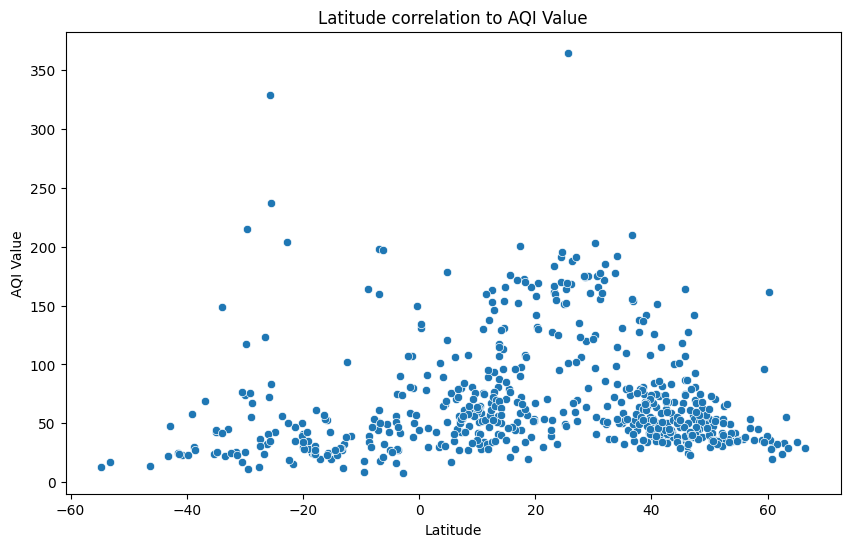

In [128]:
# Visualization of 'latitude' correlation to 'aqi_value'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mergeData, x='latitude', y='aqi_value')
plt.title("Latitude correlation to AQI Value")
plt.xlabel("Latitude")
plt.ylabel("AQI Value")
plt.show()

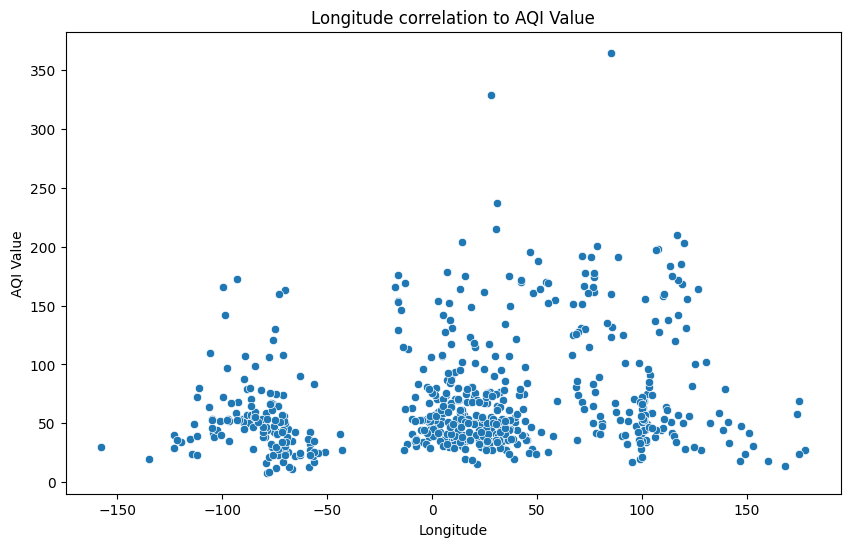

In [129]:
# Visualization of 'longitude' correlation to 'aqi_value'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mergeData, x='longitude', y='aqi_value')
plt.title("Longitude correlation to AQI Value")
plt.xlabel("Longitude")
plt.ylabel("AQI Value")
plt.show()

Data Pre-processing & Transformation

In [130]:
# Features Selection
features = mergeData[['latitude', 'longitude', 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']]
target = mergeData['aqi_value']

In [131]:
# Model Selection
RFModel = RandomForestRegressor(random_state=42)

# Set the K-Fold Cross Validation with 5 folds
KFoldSplit = KFold(n_splits=5, shuffle=True, random_state=42)

# Array to hold the value of each prediction
aqi_value_predict = np.zeros(len(mergeData))

# List to hold the MSE value of each fold
MSEScores = []

for train_index, test_index in KFoldSplit.split(features):
    # Split data into training and testing based on fold index
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Model training
    RFModel.fit(X_train, y_train)

    # Model testing
    prediction = RFModel.predict(X_test)
    
    # Saving the prediction into array
    aqi_value_predict[test_index] = prediction

    # Calculate the MSE value then add it into the list
    mse = mean_squared_error(y_test, prediction)
    MSEScores.append(mse)

# Add the prediction value as a new column in 'mergeData'
mergeData['aqi_value_predict'] = aqi_value_predict

# Calculate the average MSE value of all folds
averageMSE = np.mean(MSEScores)

Model Evaluation

In [132]:
# Display the MSE values of each fold
print("MSE values of each fold =", MSEScores)

MSE values of each fold = [np.float64(5.085391666666669), np.float64(55.185543697478984), np.float64(1.9196672268907566), np.float64(7.1393924369747905), np.float64(188.81892184873945)]


In [133]:
# Display the average MSE value of all folds
print("Average MSE value =", round(averageMSE, 2))

Average MSE value = 51.63


In [134]:
# Display and sort the importance of each features
featuresImportance = pd.Series(RFModel.feature_importances_, index=features.columns)
print(featuresImportance.sort_values(ascending=False))

pm2.5_aqi_value    0.969917
ozone_aqi_value    0.015068
co_aqi_value       0.010340
latitude           0.002597
longitude          0.001316
no2_aqi_value      0.000761
dtype: float64


Bar Plot Visualization

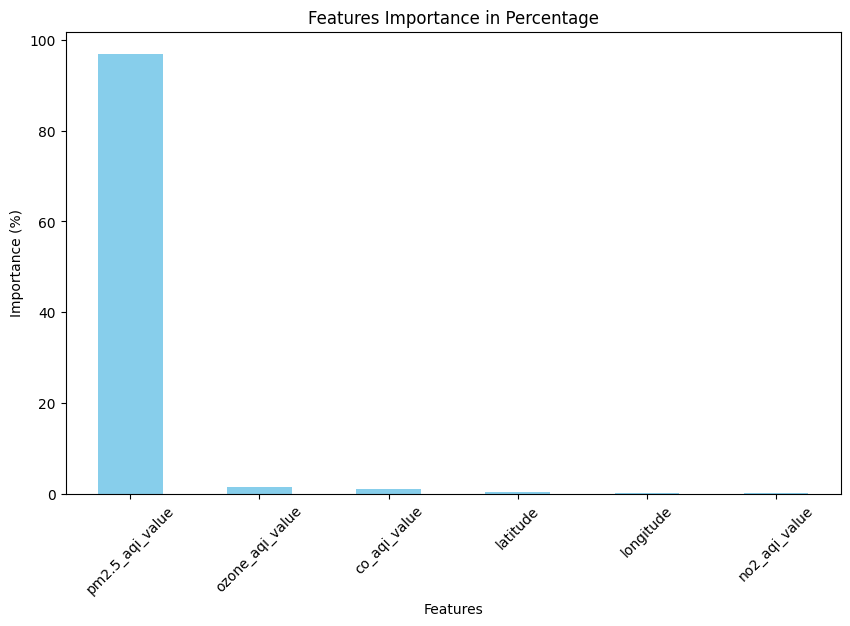

In [135]:
# Convert to DataFrame
featuresImportancesData = pd.Series(featuresImportance).sort_values(ascending=False)

# Convert to percentage
feature_importances_percent = featuresImportancesData * 100

# Visualize the importance of each features
plt.figure(figsize=(10, 6))
feature_importances_percent.plot(kind='bar', color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importance (%)")
plt.title("Features Importance in Percentage")
plt.xticks(rotation=45)
plt.show()

In [136]:
mergeData.head(596)

,city_name,country_name,latitude,longitude,aqi_value,co_aqi_value,ozone_aqi_value,no2_aqi_value,pm2.5_aqi_value,aqi_value_predict
0,Asadabad,Afghanistan,34.866000,71.150005,131,1,43,0,131,130.41
1,Peshkopi,Albania,41.683302,20.433303,115,1,39,0,115,115.22
2,Tirana,Albania,41.327541,19.818883,73,1,45,1,73,72.54
3,Adrar,Algeria,27.869990,-0.289967,106,0,45,0,106,106.82
4,Algiers,Algeria,36.763065,3.050553,154,10,33,69,154,154.96
...,...,...,...,...,...,...,...,...,...,...
591,Kabwe,Zambia,-14.440011,28.449984,27,1,19,0,27,26.87
592,Livingstone,Zambia,-17.860009,25.860013,27,1,17,0,27,26.89
593,Mongu,Zambia,-15.279598,23.120025,43,1,19,0,43,43.02
594,Harare,Zimbabwe,-17.817790,31.044709,61,3,14,2,61,61.07


In [137]:
# Calculating the percentage similarity between 'aqi_value' and 'aqi_value_predict'
mergeData['similarity_percentage'] = 100 - (abs(mergeData['aqi_value'] - mergeData['aqi_value_predict']) / mergeData['aqi_value']) * 100
average_similarity = mergeData['similarity_percentage'].mean()

print("Average similarity between 'aqi_value' and 'aqi_value_predict' =", round(average_similarity, 2), "%")

Average similarity between 'aqi_value' and 'aqi_value_predict' = 98.39 %


In [138]:
mergeData.head(596)

,city_name,country_name,latitude,longitude,aqi_value,co_aqi_value,ozone_aqi_value,no2_aqi_value,pm2.5_aqi_value,aqi_value_predict,similarity_percentage
0,Asadabad,Afghanistan,34.866000,71.150005,131,1,43,0,131,130.41,99.549618
1,Peshkopi,Albania,41.683302,20.433303,115,1,39,0,115,115.22,99.808696
2,Tirana,Albania,41.327541,19.818883,73,1,45,1,73,72.54,99.369863
3,Adrar,Algeria,27.869990,-0.289967,106,0,45,0,106,106.82,99.226415
4,Algiers,Algeria,36.763065,3.050553,154,10,33,69,154,154.96,99.376623
...,...,...,...,...,...,...,...,...,...,...,...
591,Kabwe,Zambia,-14.440011,28.449984,27,1,19,0,27,26.87,99.518519
592,Livingstone,Zambia,-17.860009,25.860013,27,1,17,0,27,26.89,99.592593
593,Mongu,Zambia,-15.279598,23.120025,43,1,19,0,43,43.02,99.953488
594,Harare,Zimbabwe,-17.817790,31.044709,61,3,14,2,61,61.07,99.885246
